<a href="https://colab.research.google.com/github/DuarteMagano/Hello-Quantum-World/blob/main/bb84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BB84

In [1]:
%%capture
%pip install qiskit==2.1.2 pylatexenc
%pip install qiskit-ibm-rutime
%pip install qiskit[visualization]

In [159]:
# imports

from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler

from qiskit.visualization import plot_histogram

from numpy.random import randint
import numpy as np

In [160]:
# set a seed for random number generation

np.random.seed(seed = 0)

In [161]:
# number of random bits generated by Alice

n = 100

### Step I: Alice generates random bits

In [162]:
alice_bits = randint(2, size = n)
print(alice_bits)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0]


### Step 2: Alice generates random basis (X or Z)

In [163]:
alice_bases = randint(2, size=n) # encoding Z<->0 and X<->1
print(alice_bases)

[1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


In [164]:
def encode_message(bits, bases):
    "list of quantum circuits that create state that alice prepared"

    message = []

    for i in range(n):

        qc = QuantumCircuit(1,1)

        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)

        qc.barrier()
        message.append(qc)

    return message

message = encode_message(alice_bits, alice_bases)

Bit choice: 1
Basis choice: 0


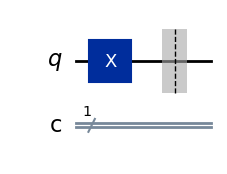

In [165]:
# example
idx = 1
print("Bit choice: {}".format(alice_bits[idx]))
print("Basis choice: {}".format(alice_bases[idx]))
message[idx].draw("mpl")

Bit choice: 1
Basis choice: 0


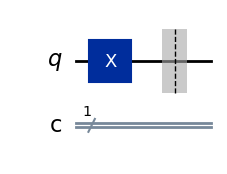

In [166]:
# example
idx = 2
print("Bit choice: {}".format(alice_bits[idx]))
print("Basis choice: {}".format(alice_bases[idx]))
message[idx].draw("mpl")

### Step 3: Bob generates random bases

In [167]:
bob_bases = randint(2, size=n) # encoding Z<->0 and X<->1
print(bob_bases)

[1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1
 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0
 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1]


### Step 4: Bob makes measurements in his basis

In [168]:
def measure_message(message, bases):

    measurements = []

    for q in range(n):

        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)

        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)

        result = StatevectorSampler().run([message[q]], shots=1).result()[0].data.c.get_counts()
        measured_bit = int(next(iter(result.keys())))

        measurements.append(measured_bit)

    return measurements

bob_results = measure_message(message, bob_bases)

### Step 5: Alice and Bob share bases

In [169]:
def remove_garbage(a_bases, b_bases, bits):

    good_bits = []

    for q in range(n):

        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])

    return good_bits

alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key   = remove_garbage(alice_bases, bob_bases, bob_results)

In [170]:
print('Alices key:', [int(bit) for bit in alice_key])
print('Bobs key:  ', bob_key)
print('New key size:', len(alice_key))

Alices key: [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Bobs key:   [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]
New key size: 48


### Step 6: Security check

In [171]:
def sample_bits(bits, selection):

    sample = []

    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in
        # the list range
        i = np.mod(i, len(bits))

        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))

    return sample

In [172]:
sample_size = 12
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str([int(bit) for bit in alice_sample]))

print("Sample length:", len(alice_sample))

  bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]
alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]
Sample length: 12


In [173]:
bob_sample == alice_sample # if there is no eavesdropping, the two samples should match

True

In [174]:
print('Alices key:', [int(bit) for bit in alice_key])
print('Bobs key:  ', bob_key)
print('New key size:', len(alice_key))

Alices key: [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]
Bobs key:   [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]
New key size: 36
